In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns;  #makes graph colors pretty
from gensim.summarization import keywords
from __future__ import print_function
import os
import re
import string
import pandas as pd
import numpy as np
import keras
sns.set()
sns.palplot(sns.color_palette("muted"))


%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))



Using TensorFlow backend.


stage1_solution_filtered.csv
stage_2_private_solution.csv
stage2_sample_submission.csv
stage2_test_text.csv
stage2_test_variants.csv
test_text
test_variants
training_text
training_variants



In [2]:
train_var = pd.read_csv("../input/training_variants")
test_var = pd.read_csv("../input/test_variants")
train_text = pd.read_csv("../input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("../input/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
#dataframe.shape returns a tuple representing dimensionality
print("Train and Test variants shape : ",train_var.shape, test_var.shape)
print("Train and Test text shape : ",train_text.shape, test_text.shape)

Train and Test variants shape :  (3321, 4) (5668, 3)
Train and Test text shape :  (3321, 2) (5668, 2)


In [3]:
#dataframe.head returns first 5 rows
#training variants
train_var.head()
train_var.describe(include='all')

,ID,Gene,Variation,Class
count,3321.000000,3321,3321,3321.000000
unique,NaN,264,2996,NaN
top,NaN,BRCA1,Truncating Mutations,NaN
freq,NaN,264,93,NaN
mean,1660.000000,NaN,NaN,4.365854
std,958.834449,NaN,NaN,2.309781
min,0.000000,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,7.000000


In [4]:
#returns first 5 rows of training text
train_text.head()
train_text.describe(include='all')

,ID,Text
count,3321.000000,3316
unique,NaN,1920
top,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,53
mean,1660.000000,NaN
std,958.834449,NaN
min,0.000000,NaN
25%,830.000000,NaN
50%,1660.000000,NaN
75%,2490.000000,NaN


In [5]:
# train_data = pd.concat([train_var_df.set_index('ID'),
#                         train_text_df.set_index('ID')],axis=1)
train_data = pd.merge(train_var, train_text, how='left',on = 'ID').fillna('')
train_data['ID'] = train_data.ID.astype(int)
train_y = train_data['Class'].values
train_x = train_data.drop('Class',axis=1)
train_size=len(train_x)
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
train_data.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [7]:
#dataframe.head returns first 5 rows
#test variants
test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [8]:
#returns first 5 rows of test text
test_text.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [9]:
# test_data = pd.concat([test_var_df.set_index('ID'),
#                         test_text_df.set_index('ID')],axis=1)
test_data = pd.merge(test_var, test_text, how='left',on = 'ID').fillna('')
test_data['ID'] = test_data.ID.astype(int)
test_data.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [10]:
test_data.describe(include='all')

,ID,Gene,Variation,Text
count,5668.000000,5668,5668,5668
unique,NaN,1397,5628,5611
top,NaN,F8,Truncating Mutations,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,134,18,6
mean,2833.500000,NaN,NaN,NaN
std,1636.354994,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1416.750000,NaN,NaN,NaN
50%,2833.500000,NaN,NaN,NaN
75%,4250.250000,NaN,NaN,NaN


In [11]:
#print 1st row from training text dataframe
with open("../input/training_text") as infile:
    for i in range(0,2):
        line = infile.readline()
        print(line)

ID,Text

0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

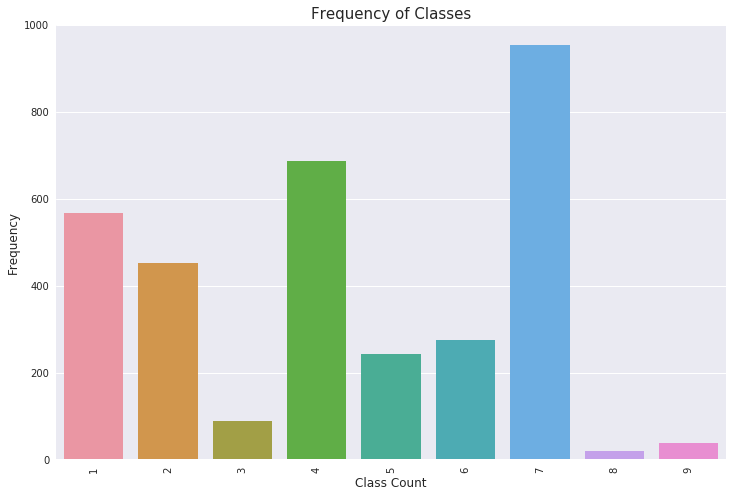

In [12]:
#frequenct of classes in training data
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_var)
plt.xlabel('Class Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [13]:
#First column is Class
#Second column is Frequency
#All in training variants file
data=train_var
data["Class"].value_counts()      

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [14]:
#print(train_data)
train_data['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

In [15]:
#drop columns gene and variation
#print(train_data)
#train_data.drop(['Gene', 'Variation'], axis=1, inplace=True)


In [16]:
#https://rare-technologies.com/text-summarization-with-gensim/
from gensim.summarization import summarize
data_id = 0
#strictly gets the text from id 0
text = train_data.loc[data_id,'Text']
#print(text)
print ('Summary:')
#could set a limit on how many words to return etc.
print (summarize(text,split=True))

Summary:
['Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells.', 'Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations.', 'ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels.', 'They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1).', 'The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2).', 'CDK10 knockdown 

In [17]:
# #algorithm tries to find words that are important 
# #or seem representative of the entire text
# from gensim.summarization import keywords
# #lemmatisation determines the lemma of a word 
# #based on its intended meaning
# trigger_words = keywords(text,words = 5,scores=True,lemmatize=True, split=True)
# print ("Keywords:")
# trigger_words =', '.join(['{}-{:.2f}'.format(i, j) for i, j in trigger_words])
# print ("["+trigger_words+"]")





In [18]:
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords
# from string import punctuation
# from scipy.misc import imresize
# from PIL import Image
# from wordcloud import WordCloud, ImageColorGenerator
# from collections import Counter

# custom_words = ["fig", "figure", "et", "al", "al.", "also",
#                 "data", "analyze", "study", "table", "using",
#                 "method", "result", "conclusion", "author", 
#                 "find", "found", "show", '"', "’", "“", "”"]

# stop_words = set(stopwords.words('english') + list(punctuation) + custom_words)
# wordnet_lemmatizer = WordNetLemmatizer()

# class_corpus = train_data.groupby('Class').apply(lambda x: x['Text'].str.cat())
# class_corpus = class_corpus.apply(lambda x: Counter(
#     [wordnet_lemmatizer.lemmatize(w) 
#      for w in word_tokenize(x) 
#      if w.lower() not in stop_words and not w.isdigit()]
# ))

In [19]:
test_index = test_data['ID'].values
all_data = np.concatenate((train_x, test_data), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]
all_data['ID'] = all_data.ID.astype(int)
print (all_data.dtypes)
all_data.head()

ID            int64
Gene         object
Variation    object
Text         object
dtype: object


,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [20]:
#figure out why there are nan objects?

In [21]:
#https://dunkley.me/blog/msk-redefining-cancer-treatment

#did not lemmatize words use Spacy lemmatizer
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
import gensim

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(gensim.utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    #only including alphanumeric symbols
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]  
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    #gets rid of punctiations
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

# all_data = all_data['Text'].str.decode("utf8")
#all_data['Text'] = all_data.Text.astype(str)
print (all_data.dtypes)
#allText = textClean(str(all_data['Text'])
allText = all_data['Text'].apply(cleanup)
#sentences = constructLabeledSentences(allText)
allText.head()


ID            int64
Gene         object
Variation    object
Text         object
dtype: object


0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [22]:
# print(train_data.dtypes)
# newtext = train_data['Text'].apply(cleanup)
# newtext.head()

In [23]:
sentences = constructLabeledSentences(allText)
sentences[0]

TaggedDocument(words=['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'vets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclindependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'm', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star', 'syndr

In [24]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=300


text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    #doc2vec
    #workers is the number of threads
    #window 
    #using words you have to create to vectorize
    #have all words in model and 
    #use that model to create the array
    #window is distance between current and predicted word
    #sample the threshold for configuring which higher-frequency words are randomly downsampled, useful range is
    #negative specifies how many noise words should be drawn
    #epochs (int) – Number of iterations (epochs) over the corpus.
    text_model = Doc2Vec(min_count=1, window=5,vector_size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, epochs=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [25]:
test_size =(len(test_data))
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

#never train with test set so you split training data into 
#training and validaition sets

#vectorization of training text
for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0

#vectorizing test data
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1

#vector for each id
#3321 points in 300 dimensional space
#text_train_arrays[0] is first vector
#len(text_train_arrays[0]) = 300
# 3321 indices
#print("Size of text_train_arrays:")

print (len(text_train_arrays))
#print (len(text_train_arrays[0]))
print(text_train_arrays[0])
#print(text_train_arrays[0][:50])

3321
[ 0.32612109  1.10098052  0.23352729 -0.21856347 -1.34712625  0.12875012
 -0.1563613  -0.22850828  0.34483543  1.24129212  1.00584924  0.19093888
 -0.46863496  0.17888574 -0.34075716  0.746566   -0.56739205  0.63683563
 -0.44720927  0.10417257 -0.36976242  1.02885103 -0.27257186 -1.00698078
 -0.20102236 -0.28299606  0.12080096 -0.08589709 -0.63092333 -0.39354348
 -0.57850182  0.69161159 -0.57779855  0.30889636  0.89184922 -0.04445522
 -0.44058552  0.54024976  0.85044235 -0.02790825 -0.60984987  0.15789792
  0.24964711 -0.12622695 -0.46135715  0.00850772  0.38353112 -0.02080632
  0.32105055  0.36049655 -0.35360581  1.21755755 -0.61670715  0.61885625
 -0.11952208 -0.32358286  0.14860865 -0.64387739  0.27324265 -0.42533648
  0.91469723  0.48722476 -0.68464696 -0.19323169 -1.31811869 -0.18215284
  0.58710361 -0.33358195 -0.73863584 -0.44497657 -0.57967633 -0.72156745
  0.76515609  0.19662744  0.55392897  0.92347729 -0.33488867 -0.08572885
  0.63535029 -0.91498435 -0.0424097  -0.482995

In [26]:
from sklearn.decomposition import TruncatedSVD
#n_components is number of dimenstions you want
Gene_INPUT_DIM=25
#we use the new k-dimensional LSI representation as we did the original
#representation – to compute similarities between vectors

#one hot encoding is representation of categorical to binary
#categoral values mapped to integer values
#integer value represented as binary vector as all zeros except index of integer
#
svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

#pd.get_dummies gets one hot encodings
one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)
#truncated = list of vectors 25 dimensions each vector representing a hot gene
one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)
print (one_hot_gene)
print(truncated_one_hot_gene[0])

      A4GALT  AAAS  AANAT  AARS  ABCA1  ABCA12  ABCA3  ABCA4  ABCB11  ABCB7  \
0          0     0      0     0      0       0      0      0       0      0   
1          0     0      0     0      0       0      0      0       0      0   
2          0     0      0     0      0       0      0      0       0      0   
3          0     0      0     0      0       0      0      0       0      0   
4          0     0      0     0      0       0      0      0       0      0   
5          0     0      0     0      0       0      0      0       0      0   
6          0     0      0     0      0       0      0      0       0      0   
7          0     0      0     0      0       0      0      0       0      0   
8          0     0      0     0      0       0      0      0       0      0   
9          0     0      0     0      0       0      0      0       0      0   
10         0     0      0     0      0       0      0      0       0      0   
11         0     0      0     0      0       0      

In [27]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

#train_y = train['Class'].values
#train_y is classes
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
#print(encoded_y[0])
print(encoded_y)
print(len(encoded_y))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
3321


In [28]:
#np.hstack concatenates arrays together
#train_set is array of 300+25+25
#vectorized one hot gene/variation/and text

#same thing with test set
#vectorized all important info
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
print(len(text_train_arrays))
#first 50 dimensions of first 
print(len(train_set[0]))
print(train_set[0])
#print(train_set[0][:50])

3321
350
[-7.49643297e-25  1.22117800e-19 -4.58299851e-21 -1.44003288e-21
 -1.09935035e-21  2.06646361e-22 -7.89551436e-25  1.64731032e-25
  6.57163664e-29 -6.12860971e-29  3.20504338e-30 -3.88537861e-30
  2.07133117e-30  6.20907477e-29 -5.90167924e-29  1.06155422e-29
  3.67539707e-29 -9.93688594e-29 -2.62003300e-28 -1.71947790e-28
  2.24805835e-27 -1.64492271e-28  4.24883912e-27  1.25756374e-26
 -1.25938455e-26  1.00000000e+00 -6.02524318e-19 -9.74719481e-19
  4.60651467e-27  2.57911088e-27  1.30547889e-22  9.67527378e-23
 -1.42232091e-21 -5.73481053e-21  1.52541981e-20  5.52507164e-21
  2.12490166e-21  1.63961718e-21  1.14402561e-20 -2.91292066e-18
 -3.24594047e-17 -9.02906057e-18  8.89809645e-18 -6.03695211e-18
  2.90823505e-17 -2.01230588e-17  3.15071058e-17 -2.30652741e-17
 -3.56080739e-17 -7.79218674e-18  3.26121092e-01  1.10098052e+00
  2.33527288e-01 -2.18563467e-01 -1.34712625e+00  1.28750116e-01
 -1.56361297e-01 -2.28508279e-01  3.44835430e-01  1.24129212e+00
  1.00584924e+00

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
#https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
#connecting each neuron to next neuron to next layer(Dense)

#dense is connecting layers together
#dropout - randomly draw connections between neurons
#Text_INPUT_DIM=300 = input_dim = expected 300 variables
#total input dimension is 350
#fully connected layers are defined using the Dense class
def baseline_model():
    #sequental is linear stack of layers
    #pass list of layers
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu')) #convolution layer 1
    model.add(Dropout(0.3)) #max pooling - shrinks input 
    model.add(Dense(256, init='normal', activation='relu')) #convolution layer 2
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu')) #other link has 100 neurons, fully connected layer
    model.add(Dense(9, init='normal', activation="softmax")) #output layer has 9 neurons classification output layer
    
    #gradient descent optimizer
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [30]:
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
_________________________________________________________________


/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=350, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`


In [31]:
#validation for training accuracy
#accuracy 
#validation
#valuation loss
#80% train data 20% validation data
#validation 
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=10, batch_size=64)


Train on 2656 samples, validate on 665 samples
Epoch 1/10
2656/2656 [==============================] - 0s 130us/step - loss: 1.9729 - acc: 0.2590 - val_loss: 1.9501 - val_acc: 0.3774
Epoch 2/10
2656/2656 [==============================] - 0s 42us/step - loss: 1.7826 - acc: 0.3332 - val_loss: 1.7822 - val_acc: 0.3624
Epoch 3/10
2656/2656 [==============================] - 0s 42us/step - loss: 1.6114 - acc: 0.4224 - val_loss: 1.6658 - val_acc: 0.3474
Epoch 4/10
2656/2656 [==============================] - 0s 39us/step - loss: 1.5062 - acc: 0.4443 - val_loss: 1.7068 - val_acc: 0.3203
Epoch 5/10
2656/2656 [==============================] - 0s 39us/step - loss: 1.4355 - acc: 0.4736 - val_loss: 1.6704 - val_acc: 0.3504
Epoch 6/10
2656/2656 [==============================] - 0s 40us/step - loss: 1.3633 - acc: 0.4936 - val_loss: 1.7386 - val_acc: 0.3293
Epoch 7/10
2656/2656 [==============================] - 0s 38us/step - loss: 1.3305 - acc: 0.5072 - val_loss: 1.6921 - val_acc: 0.3474
Epoch 8

In [32]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 56.59% / Validation accuracy: 35.49%


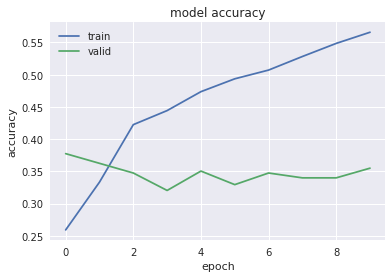

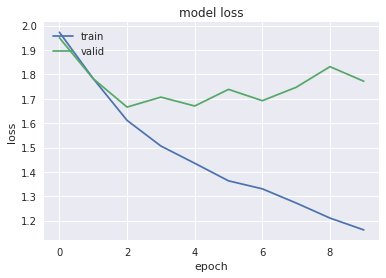

In [33]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [107]:
y_pred = model.predict_proba(test_set)


In [108]:
submission = pd.DataFrame(y_pred)
# print(test_index)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']

In [109]:
for row in range(submission['id'].size):
    max = 0
    maxCol = 'class1'
    #hello
    for col in submission.columns[:-1]:
        print(col)
        cur = submission.at[row, col]
        if cur > max:
            print(cur, ' > ', max)
            max = cur
            submission.at[row, maxCol] = 0
            submission.at[row, col] = 1
            maxCol = col
        else:
            print(cur, ' <= ', max)
            submission.at[row, col] = 0

class1
0.0010423576  >  0
class2
0.17496653  >  0.0010423576
class3
0.0066788485  <=  0.17496653
class4
0.0004615905  <=  0.17496653
class5
0.013004322  <=  0.17496653
class6
0.024437943  <=  0.17496653
class7
0.77815443  >  0.17496653
class8
0.00046088974  <=  0.77815443
class9
0.0007931015  <=  0.77815443
class1
0.3161038  >  0
class2
0.027673978  <=  0.3161038
class3
0.023683526  <=  0.3161038
class4
0.45136997  >  0.3161038
class5
0.07432614  <=  0.45136997
class6
0.06322972  <=  0.45136997
class7
0.019791748  <=  0.45136997
class8
0.007621148  <=  0.45136997
class9
0.016199967  <=  0.45136997
class1
0.47229233  >  0
class2
0.11789474  <=  0.47229233
class3
0.015276886  <=  0.47229233
class4
0.06746719  <=  0.47229233
class5
0.07063736  <=  0.47229233
class6
0.06550705  <=  0.47229233
class7
0.18042243  <=  0.47229233
class8
0.0030904582  <=  0.47229233
class9
0.0074115135  <=  0.47229233
class1
0.002597765  >  0
class2
0.25608695  >  0.002597765
class3
0.002225305  <=  0.25608695


class4
0.21267009  <=  0.48626822
class5
0.044371027  <=  0.48626822
class6
0.012053154  <=  0.48626822
class7
0.0928879  <=  0.48626822
class8
0.0019177013  <=  0.48626822
class9
0.0036954053  <=  0.48626822
class1
0.43479162  >  0
class2
0.02881096  <=  0.43479162
class3
0.014231766  <=  0.43479162
class4
0.42424697  <=  0.43479162
class5
0.048509657  <=  0.43479162
class6
0.013888586  <=  0.43479162
class7
0.026440583  <=  0.43479162
class8
0.0030431778  <=  0.43479162
class9
0.0060366504  <=  0.43479162
class1
0.29645938  >  0
class2
0.070647284  <=  0.29645938
class3
0.025529606  <=  0.29645938
class4
0.05751448  <=  0.29645938
class5
0.12624882  <=  0.29645938
class6
0.31880367  >  0.29645938
class7
0.06665454  <=  0.31880367
class8
0.011227749  <=  0.31880367
class9
0.026914528  <=  0.31880367
class1
0.12789093  >  0
class2
0.27970013  >  0.12789093
class3
0.011640804  <=  0.27970013
class4
0.023345623  <=  0.27970013
class5
0.03460922  <=  0.27970013
class6
0.02733847  <=  0.27

class1
0.49252102  >  0
class2
0.013421621  <=  0.49252102
class3
0.021461958  <=  0.49252102
class4
0.31671795  <=  0.49252102
class5
0.08269402  <=  0.49252102
class6
0.028426846  <=  0.49252102
class7
0.03787212  <=  0.49252102
class8
0.002578196  <=  0.49252102
class9
0.004306222  <=  0.49252102
class1
0.6621427  >  0
class2
0.014263379  <=  0.6621427
class3
0.0055515994  <=  0.6621427
class4
0.19331048  <=  0.6621427
class5
0.05180063  <=  0.6621427
class6
0.05612837  <=  0.6621427
class7
0.0037808577  <=  0.6621427
class8
0.0029653292  <=  0.6621427
class9
0.010056608  <=  0.6621427
class1
0.010682906  >  0
class2
0.30422038  >  0.010682906
class3
0.027248846  <=  0.30422038
class4
0.005118939  <=  0.30422038
class5
0.05143557  <=  0.30422038
class6
0.10873474  <=  0.30422038
class7
0.476416  >  0.30422038
class8
0.005654877  <=  0.476416
class9
0.010487681  <=  0.476416
class1
0.58093435  >  0
class2
0.0025027215  <=  0.58093435
class3
0.007697421  <=  0.58093435
class4
0.213817

0.0068267947  <=  0.31773874
class1
0.81892264  >  0
class2
4.9125188e-06  <=  0.81892264
class3
4.9533504e-05  <=  0.81892264
class4
0.17893705  <=  0.81892264
class5
0.0016163941  <=  0.81892264
class6
0.000456747  <=  0.81892264
class7
3.2645942e-06  <=  0.81892264
class8
1.0655409e-06  <=  0.81892264
class9
8.37429e-06  <=  0.81892264
class1
0.0010004394  >  0
class2
0.23535235  >  0.0010004394
class3
0.0142118335  <=  0.23535235
class4
0.00053075375  <=  0.23535235
class5
0.028367862  <=  0.23535235
class6
0.05947068  <=  0.23535235
class7
0.65843976  >  0.23535235
class8
0.0009127156  <=  0.65843976
class9
0.0017135508  <=  0.65843976
class1
0.30780467  >  0
class2
0.13094217  <=  0.30780467
class3
0.021349909  <=  0.30780467
class4
0.105373226  <=  0.30780467
class5
0.111342125  <=  0.30780467
class6
0.2084147  <=  0.30780467
class7
0.0750346  <=  0.30780467
class8
0.011873476  <=  0.30780467
class9
0.027865097  <=  0.30780467
class1
0.04198254  >  0
class2
0.44116965  >  0.0419

0.8436393  >  0.13701949
class8
0.00026812614  <=  0.8436393
class9
0.00034479436  <=  0.8436393
class1
0.05261919  >  0
class2
0.42173174  >  0.05261919
class3
0.017449502  <=  0.42173174
class4
0.02581601  <=  0.42173174
class5
0.035064198  <=  0.42173174
class6
0.01733507  <=  0.42173174
class7
0.41629812  <=  0.42173174
class8
0.0055816323  <=  0.42173174
class9
0.008104546  <=  0.42173174
class1
0.16274677  >  0
class2
0.14591762  <=  0.16274677
class3
0.023878561  <=  0.16274677
class4
0.13268605  <=  0.16274677
class5
0.043025292  <=  0.16274677
class6
0.0125488015  <=  0.16274677
class7
0.4720481  >  0.16274677
class8
0.0029559543  <=  0.4720481
class9
0.004192913  <=  0.4720481
class1
0.08421716  >  0
class2
0.35114977  >  0.08421716
class3
0.012623076  <=  0.35114977
class4
0.016223291  <=  0.35114977
class5
0.043383863  <=  0.35114977
class6
0.031914044  <=  0.35114977
class7
0.45168433  >  0.35114977
class8
0.0029499012  <=  0.45168433
class9
0.0058545657  <=  0.45168433
cl

0.011566015  <=  0.17379336
class6
0.014786966  <=  0.17379336
class7
0.78916186  >  0.17379336
class8
0.0005544359  <=  0.78916186
class9
0.00074783387  <=  0.78916186
class1
0.25015795  >  0
class2
0.15252155  <=  0.25015795
class3
0.037730843  <=  0.25015795
class4
0.2336359  <=  0.25015795
class5
0.09769723  <=  0.25015795
class6
0.062054068  <=  0.25015795
class7
0.14110138  <=  0.25015795
class8
0.0092143575  <=  0.25015795
class9
0.015886731  <=  0.25015795
class1
0.10395614  >  0
class2
0.28417036  >  0.10395614
class3
0.05044036  <=  0.28417036
class4
0.060923792  <=  0.28417036
class5
0.06495512  <=  0.28417036
class6
0.050736614  <=  0.28417036
class7
0.2923281  >  0.28417036
class8
0.037048396  <=  0.2923281
class9
0.055441145  <=  0.2923281
class1
0.011045354  >  0
class2
0.4100966  >  0.011045354
class3
0.01362093  <=  0.4100966
class4
0.009016241  <=  0.4100966
class5
0.028653324  <=  0.4100966
class6
0.017044164  <=  0.4100966
class7
0.5081978  >  0.4100966
class8
0.001

class1
0.4711158  >  0
class2
0.0011702856  <=  0.4711158
class3
0.0049873334  <=  0.4711158
class4
0.48516452  >  0.4711158
class5
0.027577525  <=  0.48516452
class6
0.007440785  <=  0.48516452
class7
0.00094839203  <=  0.48516452
class8
0.00042311652  <=  0.48516452
class9
0.0011723068  <=  0.48516452
class1
0.7864902  >  0
class2
0.0016624713  <=  0.7864902
class3
0.00147755  <=  0.7864902
class4
0.19323947  <=  0.7864902
class5
0.010376547  <=  0.7864902
class6
0.0046991315  <=  0.7864902
class7
0.0007982378  <=  0.7864902
class8
0.00023576361  <=  0.7864902
class9
0.0010206165  <=  0.7864902
class1
0.0031017086  >  0
class2
0.1602395  >  0.0031017086
class3
0.01062279  <=  0.1602395
class4
0.0020321626  <=  0.1602395
class5
0.02030187  <=  0.1602395
class6
0.0149195315  <=  0.1602395
class7
0.7871845  >  0.1602395
class8
0.00071178883  <=  0.7871845
class9
0.0008860944  <=  0.7871845
class1
0.29081315  >  0
class2
0.026930925  <=  0.29081315
class3
0.03248952  <=  0.29081315
class

0.011330821  <=  0.30365533
class7
0.58072805  >  0.30365533
class8
0.0026892866  <=  0.58072805
class9
0.0033039222  <=  0.58072805
class1
0.11448844  >  0
class2
0.3889168  >  0.11448844
class3
0.024117237  <=  0.3889168
class4
0.11610514  <=  0.3889168
class5
0.0608385  <=  0.3889168
class6
0.055857114  <=  0.3889168
class7
0.22672641  <=  0.3889168
class8
0.00520879  <=  0.3889168
class9
0.007741476  <=  0.3889168
class1
0.60553443  >  0
class2
0.0003665664  <=  0.60553443
class3
0.0017160652  <=  0.60553443
class4
0.3682497  <=  0.60553443
class5
0.017063143  <=  0.60553443
class6
0.0062135616  <=  0.60553443
class7
0.00024525548  <=  0.60553443
class8
0.000120849414  <=  0.60553443
class9
0.00049041014  <=  0.60553443
class1
0.060415242  >  0
class2
0.2998099  >  0.060415242
class3
0.008754307  <=  0.2998099
class4
0.01729086  <=  0.2998099
class5
0.031688336  <=  0.2998099
class6
0.019575827  <=  0.2998099
class7
0.55704576  >  0.2998099
class8
0.0022029055  <=  0.55704576
class

0.0039044213  <=  0.13753156
class7
0.80737627  >  0.13753156
class8
0.0009171882  <=  0.80737627
class9
0.0010019367  <=  0.80737627
class1
0.42371628  >  0
class2
0.011288916  <=  0.42371628
class3
0.030834673  <=  0.42371628
class4
0.3238471  <=  0.42371628
class5
0.11792369  <=  0.42371628
class6
0.069335416  <=  0.42371628
class7
0.012676628  <=  0.42371628
class8
0.0032795242  <=  0.42371628
class9
0.0070977593  <=  0.42371628
class1
0.0017320184  >  0
class2
0.27146244  >  0.0017320184
class3
0.0015432049  <=  0.27146244
class4
0.000491794  <=  0.27146244
class5
0.0039770696  <=  0.27146244
class6
0.0018514592  <=  0.27146244
class7
0.71866137  >  0.27146244
class8
0.00012904248  <=  0.71866137
class9
0.00015156841  <=  0.71866137
class1
0.22846372  >  0
class2
0.012468018  <=  0.22846372
class3
0.051866513  <=  0.22846372
class4
0.48961967  >  0.22846372
class5
0.11840868  <=  0.48961967
class6
0.059036627  <=  0.48961967
class7
0.022160338  <=  0.48961967
class8
0.0054010516  

class4
0.2874449  >  0.18146224
class5
0.105220675  <=  0.2874449
class6
0.06322782  <=  0.2874449
class7
0.10336877  <=  0.2874449
class8
0.032330833  <=  0.2874449
class9
0.054703306  <=  0.2874449
class1
0.031258274  >  0
class2
0.34216475  >  0.031258274
class3
0.020229794  <=  0.34216475
class4
0.022194253  <=  0.34216475
class5
0.040323872  <=  0.34216475
class6
0.018459236  <=  0.34216475
class7
0.51149565  >  0.34216475
class8
0.0058569373  <=  0.51149565
class9
0.008017178  <=  0.51149565
class1
0.387316  >  0
class2
0.0030946024  <=  0.387316
class3
0.016680589  <=  0.387316
class4
0.48298576  >  0.387316
class5
0.064361595  <=  0.48298576
class6
0.036388934  <=  0.48298576
class7
0.0030708686  <=  0.48298576
class8
0.001767896  <=  0.48298576
class9
0.0043338146  <=  0.48298576
class1
0.021244574  >  0
class2
0.3037914  >  0.021244574
class3
0.009688504  <=  0.3037914
class4
0.0026728145  <=  0.3037914
class5
0.026432367  <=  0.3037914
class6
0.036171615  <=  0.3037914
class

class2
0.080258936  <=  0.44295168
class3
0.024877567  <=  0.44295168
class4
0.13160598  <=  0.44295168
class5
0.076638125  <=  0.44295168
class6
0.022875393  <=  0.44295168
class7
0.2043038  <=  0.44295168
class8
0.006255962  <=  0.44295168
class9
0.0102325985  <=  0.44295168
class1
0.027633343  >  0
class2
0.20516628  >  0.027633343
class3
0.020603882  <=  0.20516628
class4
0.089826986  <=  0.20516628
class5
0.028525954  <=  0.20516628
class6
0.0029465528  <=  0.20516628
class7
0.6241822  >  0.20516628
class8
0.0005083475  <=  0.6241822
class9
0.00060640863  <=  0.6241822
class1
0.45438072  >  0
class2
0.0665818  <=  0.45438072
class3
0.033285506  <=  0.45438072
class4
0.12590392  <=  0.45438072
class5
0.10006368  <=  0.45438072
class6
0.073888145  <=  0.45438072
class7
0.111446425  <=  0.45438072
class8
0.01217982  <=  0.45438072
class9
0.022270007  <=  0.45438072
class1
0.001657837  >  0
class2
0.20334233  >  0.001657837
class3
0.0052140965  <=  0.20334233
class4
0.0004570438  <=  

0.3666573  >  0
class2
0.00033197494  <=  0.3666573
class3
0.0027571681  <=  0.3666573
class4
0.6126243  >  0.3666573
class5
0.013750383  <=  0.6126243
class6
0.002869905  <=  0.6126243
class7
0.0007231683  <=  0.6126243
class8
8.092619e-05  <=  0.6126243
class9
0.00020489181  <=  0.6126243
class1
0.0076755485  >  0
class2
0.351398  >  0.0076755485
class3
0.008454622  <=  0.351398
class4
0.0023010292  <=  0.351398
class5
0.019686991  <=  0.351398
class6
0.0204349  <=  0.351398
class7
0.5843631  >  0.351398
class8
0.00232548  <=  0.5843631
class9
0.0033603504  <=  0.5843631
class1
0.034269623  >  0
class2
0.30151927  >  0.034269623
class3
0.04420596  <=  0.30151927
class4
0.026953641  <=  0.30151927
class5
0.06185672  <=  0.30151927
class6
0.039623436  <=  0.30151927
class7
0.46969584  >  0.30151927
class8
0.009181114  <=  0.46969584
class9
0.012694396  <=  0.46969584
class1
0.008576475  >  0
class2
0.24241757  >  0.008576475
class3
0.009672027  <=  0.24241757
class4
0.0022235853  <=  0

0.0030888934  <=  0.7622923
class8
0.0005041542  <=  0.7622923
class9
0.0009574394  <=  0.7622923
class1
0.0016256406  >  0
class2
0.2765245  >  0.0016256406
class3
0.010931513  <=  0.2765245
class4
0.0007810344  <=  0.2765245
class5
0.024046555  <=  0.2765245
class6
0.049930543  <=  0.2765245
class7
0.6336339  >  0.2765245
class8
0.0010003077  <=  0.6336339
class9
0.0015259483  <=  0.6336339
class1
0.002820261  >  0
class2
0.20149186  >  0.002820261
class3
0.014286811  <=  0.20149186
class4
0.00168866  <=  0.20149186
class5
0.03447532  <=  0.20149186
class6
0.08989101  <=  0.20149186
class7
0.65191376  >  0.20149186
class8
0.0012779265  <=  0.65191376
class9
0.0021544013  <=  0.65191376
class1
0.060949337  >  0
class2
0.35713416  >  0.060949337
class3
0.02128878  <=  0.35713416
class4
0.030232415  <=  0.35713416
class5
0.044340253  <=  0.35713416
class6
0.025480112  <=  0.35713416
class7
0.43539837  >  0.35713416
class8
0.009896986  <=  0.43539837
class9
0.015279606  <=  0.43539837
cl

0.016980734  <=  0.5941169
class6
0.0021778897  <=  0.5941169
class7
0.0009367013  <=  0.5941169
class8
0.00012380663  <=  0.5941169
class9
0.00029039787  <=  0.5941169
class1
0.0015279544  >  0
class2
0.23322165  >  0.0015279544
class3
0.009355728  <=  0.23322165
class4
0.00083294616  <=  0.23322165
class5
0.025336172  <=  0.23322165
class6
0.04838748  <=  0.23322165
class7
0.6795427  >  0.23322165
class8
0.0007513639  <=  0.6795427
class9
0.0010439183  <=  0.6795427
class1
0.6296325  >  0
class2
0.02071526  <=  0.6296325
class3
0.006282978  <=  0.6296325
class4
0.27133977  <=  0.6296325
class5
0.03148356  <=  0.6296325
class6
0.015878035  <=  0.6296325
class7
0.020841377  <=  0.6296325
class8
0.0012030293  <=  0.6296325
class9
0.0026235848  <=  0.6296325
class1
0.8132359  >  0
class2
0.015667513  <=  0.8132359
class3
0.004552919  <=  0.8132359
class4
0.078116015  <=  0.8132359
class5
0.039265443  <=  0.8132359
class6
0.031109534  <=  0.8132359
class7
0.006406036  <=  0.8132359
class8

0.009342528  <=  0.5392984
class4
0.32414156  <=  0.5392984
class5
0.04811586  <=  0.5392984
class6
0.021935694  <=  0.5392984
class7
0.018359141  <=  0.5392984
class8
0.0041095107  <=  0.5392984
class9
0.008563392  <=  0.5392984
class1
0.36649394  >  0
class2
0.11882917  <=  0.36649394
class3
0.035851456  <=  0.36649394
class4
0.1422046  <=  0.36649394
class5
0.10294296  <=  0.36649394
class6
0.055728033  <=  0.36649394
class7
0.13592549  <=  0.36649394
class8
0.014757168  <=  0.36649394
class9
0.027267138  <=  0.36649394
class1
0.12874734  >  0
class2
0.18208945  >  0.12874734
class3
0.04827842  <=  0.18208945
class4
0.22334307  >  0.18208945
class5
0.12487002  <=  0.22334307
class6
0.13078272  <=  0.22334307
class7
0.14655079  <=  0.22334307
class8
0.0063698255  <=  0.22334307
class9
0.008968326  <=  0.22334307
class1
0.21521452  >  0
class2
0.3584921  >  0.21521452
class3
0.011804685  <=  0.3584921
class4
0.08041853  <=  0.3584921
class5
0.028473992  <=  0.3584921
class6
0.01430499

0.024102978  >  0
class2
0.38491353  >  0.024102978
class3
0.023557173  <=  0.38491353
class4
0.016214384  <=  0.38491353
class5
0.06687494  <=  0.38491353
class6
0.113866374  <=  0.38491353
class7
0.35710195  <=  0.38491353
class8
0.005056699  <=  0.38491353
class9
0.008311894  <=  0.38491353
class1
0.09629425  >  0
class2
0.11713442  >  0.09629425
class3
0.041621633  <=  0.11713442
class4
0.32536545  >  0.11713442
class5
0.066285685  <=  0.32536545
class6
0.014435306  <=  0.32536545
class7
0.3336958  >  0.32536545
class8
0.0023126404  <=  0.3336958
class9
0.0028547524  <=  0.3336958
class1
0.01830615  >  0
class2
0.15407687  >  0.01830615
class3
0.01117677  <=  0.15407687
class4
0.005449918  <=  0.15407687
class5
0.02148677  <=  0.15407687
class6
0.01067299  <=  0.15407687
class7
0.7750347  >  0.15407687
class8
0.0016954924  <=  0.7750347
class9
0.002100274  <=  0.7750347
class1
0.0034082483  >  0
class2
0.3937793  >  0.0034082483
class3
0.004305113  <=  0.3937793
class4
0.0010036391

class1
0.0025894311  >  0
class2
0.37497807  >  0.0025894311
class3
0.0045003616  <=  0.37497807
class4
0.001269691  <=  0.37497807
class5
0.014684982  <=  0.37497807
class6
0.01825712  <=  0.37497807
class7
0.5828063  >  0.37497807
class8
0.0003814819  <=  0.5828063
class9
0.0005325749  <=  0.5828063
class1
0.47698212  >  0
class2
0.068322875  <=  0.47698212
class3
0.01687517  <=  0.47698212
class4
0.25862408  <=  0.47698212
class5
0.052913193  <=  0.47698212
class6
0.029648766  <=  0.47698212
class7
0.08739721  <=  0.47698212
class8
0.0032273885  <=  0.47698212
class9
0.0060092653  <=  0.47698212
class1
0.33482352  >  0
class2
0.00472318  <=  0.33482352
class3
0.031781595  <=  0.33482352
class4
0.36237338  >  0.33482352
class5
0.14366733  <=  0.36237338
class6
0.105093345  <=  0.36237338
class7
0.0030718306  <=  0.36237338
class8
0.0038951526  <=  0.36237338
class9
0.010570744  <=  0.36237338
class1
0.75786734  >  0
class2
0.0077986475  <=  0.75786734
class3
0.004648944  <=  0.757867

class8
0.0009479343  <=  0.67519385
class9
0.0016538794  <=  0.67519385
class1
0.5565569  >  0
class2
0.062084705  <=  0.5565569
class3
0.016532782  <=  0.5565569
class4
0.123526216  <=  0.5565569
class5
0.07284817  <=  0.5565569
class6
0.03954178  <=  0.5565569
class7
0.12261528  <=  0.5565569
class8
0.0019930697  <=  0.5565569
class9
0.00430121  <=  0.5565569
class1
0.56238574  >  0
class2
0.022946496  <=  0.56238574
class3
0.0098949205  <=  0.56238574
class4
0.32306263  <=  0.56238574
class5
0.041990817  <=  0.56238574
class6
0.013112642  <=  0.56238574
class7
0.018072011  <=  0.56238574
class8
0.0029323457  <=  0.56238574
class9
0.0056024073  <=  0.56238574
class1
0.32723662  >  0
class2
0.063824765  <=  0.32723662
class3
0.04591541  <=  0.32723662
class4
0.1918886  <=  0.32723662
class5
0.13311304  <=  0.32723662
class6
0.14108129  <=  0.32723662
class7
0.043159842  <=  0.32723662
class8
0.018759307  <=  0.32723662
class9
0.035021123  <=  0.32723662
class1
0.018168883  >  0
class2

class6
0.0754908  <=  0.3774704
class7
0.26464364  <=  0.3774704
class8
0.024995599  <=  0.3774704
class9
0.037177708  <=  0.3774704
class1
0.2585985  >  0
class2
0.16375689  <=  0.2585985
class3
0.044090305  <=  0.2585985
class4
0.24320814  <=  0.2585985
class5
0.085926674  <=  0.2585985
class6
0.03690983  <=  0.2585985
class7
0.12420431  <=  0.2585985
class8
0.016223088  <=  0.2585985
class9
0.027082339  <=  0.2585985
class1
0.08144125  >  0
class2
0.2969446  >  0.08144125
class3
0.028186299  <=  0.2969446
class4
0.07298643  <=  0.2969446
class5
0.04226927  <=  0.2969446
class6
0.02007854  <=  0.2969446
class7
0.44390568  >  0.2969446
class8
0.005863406  <=  0.44390568
class9
0.008324559  <=  0.44390568
class1
0.44327298  >  0
class2
0.13692433  <=  0.44327298
class3
0.011375081  <=  0.44327298
class4
0.20191781  <=  0.44327298
class5
0.04113589  <=  0.44327298
class6
0.012266596  <=  0.44327298
class7
0.14449574  <=  0.44327298
class8
0.0029516239  <=  0.44327298
class9
0.0056599556

class1
0.38626525  >  0
class2
0.011003347  <=  0.38626525
class3
0.0185207  <=  0.38626525
class4
0.4826267  >  0.38626525
class5
0.061792444  <=  0.4826267
class6
0.022360157  <=  0.4826267
class7
0.011929605  <=  0.4826267
class8
0.0018525732  <=  0.4826267
class9
0.0036492154  <=  0.4826267
class1
0.015777454  >  0
class2
0.2155377  >  0.015777454
class3
0.0052410546  <=  0.2155377
class4
0.008711884  <=  0.2155377
class5
0.010019986  <=  0.2155377
class6
0.0035499278  <=  0.2155377
class7
0.74004316  >  0.2155377
class8
0.00052623055  <=  0.74004316
class9
0.0005925985  <=  0.74004316
class1
0.01748642  >  0
class2
0.33450302  >  0.01748642
class3
0.010865947  <=  0.33450302
class4
0.014129637  <=  0.33450302
class5
0.01932549  <=  0.33450302
class6
0.010899836  <=  0.33450302
class7
0.5895708  >  0.33450302
class8
0.0013681726  <=  0.5895708
class9
0.0018506238  <=  0.5895708
class1
0.45743623  >  0
class2
0.0023650771  <=  0.45743623
class3
0.0034225935  <=  0.45743623
class4
0.

0.20049466  >  0.043091707
class3
0.011669163  <=  0.20049466
class4
0.034142416  <=  0.20049466
class5
0.017223328  <=  0.20049466
class6
0.004486874  <=  0.20049466
class7
0.6849527  >  0.20049466
class8
0.0018019776  <=  0.6849527
class9
0.0021372156  <=  0.6849527
class1
0.0035573153  >  0
class2
0.40060565  >  0.0035573153
class3
0.0019919658  <=  0.40060565
class4
0.0005112853  <=  0.40060565
class5
0.0066383546  <=  0.40060565
class6
0.007540898  <=  0.40060565
class7
0.5777902  >  0.40060565
class8
0.00057064905  <=  0.5777902
class9
0.000793708  <=  0.5777902
class1
0.0665463  >  0
class2
0.31671086  >  0.0665463
class3
0.02538358  <=  0.31671086
class4
0.04512234  <=  0.31671086
class5
0.042636067  <=  0.31671086
class6
0.024250934  <=  0.31671086
class7
0.45342642  >  0.31671086
class8
0.010915962  <=  0.45342642
class9
0.015007599  <=  0.45342642
class1
0.18345417  >  0
class2
0.0756108  <=  0.18345417
class3
0.08201005  <=  0.18345417
class4
0.09884451  <=  0.18345417
clas

0.0006561504  <=  0.6632192
class1
0.06263425  >  0
class2
0.16825029  >  0.06263425
class3
0.03378479  <=  0.16825029
class4
0.04804685  <=  0.16825029
class5
0.066350386  <=  0.16825029
class6
0.027674707  <=  0.16825029
class7
0.5837383  >  0.16825029
class8
0.0042610993  <=  0.5837383
class9
0.0052592945  <=  0.5837383
class1
0.39412466  >  0
class2
0.15771873  <=  0.39412466
class3
0.022889461  <=  0.39412466
class4
0.11861931  <=  0.39412466
class5
0.0752352  <=  0.39412466
class6
0.10451495  <=  0.39412466
class7
0.08425594  <=  0.39412466
class8
0.011582046  <=  0.39412466
class9
0.031059757  <=  0.39412466
class1
0.29661834  >  0
class2
0.0076950835  <=  0.29661834
class3
0.026460871  <=  0.29661834
class4
0.56291777  >  0.29661834
class5
0.06557741  <=  0.56291777
class6
0.025451612  <=  0.56291777
class7
0.008191478  <=  0.56291777
class8
0.0024233775  <=  0.56291777
class9
0.0046640043  <=  0.56291777
class1
0.18712136  >  0
class2
0.045146625  <=  0.18712136
class3
0.01503

0.00050839287  <=  0.62128323
class9
0.0008277829  <=  0.62128323
class1
0.034589212  >  0
class2
0.20164208  >  0.034589212
class3
0.033165634  <=  0.20164208
class4
0.017000597  <=  0.20164208
class5
0.072525576  <=  0.20164208
class6
0.08290513  <=  0.20164208
class7
0.5329045  >  0.20164208
class8
0.010302728  <=  0.5329045
class9
0.014964516  <=  0.5329045
class1
0.14913894  >  0
class2
0.12406376  <=  0.14913894
class3
0.03071967  <=  0.14913894
class4
0.22221279  >  0.14913894
class5
0.087351896  <=  0.22221279
class6
0.07287069  <=  0.22221279
class7
0.30463085  >  0.22221279
class8
0.0032200553  <=  0.30463085
class9
0.005791384  <=  0.30463085
class1
0.035607688  >  0
class2
0.12789224  >  0.035607688
class3
0.0424376  <=  0.12789224
class4
0.033944756  <=  0.12789224
class5
0.079265304  <=  0.12789224
class6
0.07481786  <=  0.12789224
class7
0.59857756  >  0.12789224
class8
0.0033526921  <=  0.59857756
class9
0.004104229  <=  0.59857756
class1
0.0074920813  >  0
class2
0.642

0.022642815  <=  0.4749543
class7
0.4713791  <=  0.4749543
class8
0.0016336865  <=  0.4749543
class9
0.0023689242  <=  0.4749543
class1
0.1289546  >  0
class2
0.19061218  >  0.1289546
class3
0.069905244  <=  0.19061218
class4
0.14619249  <=  0.19061218
class5
0.07554457  <=  0.19061218
class6
0.037949372  <=  0.19061218
class7
0.29287124  >  0.19061218
class8
0.024557333  <=  0.29287124
class9
0.033413015  <=  0.29287124
class1
0.22331649  >  0
class2
0.15158877  <=  0.22331649
class3
0.056631498  <=  0.22331649
class4
0.11761042  <=  0.22331649
class5
0.10401908  <=  0.22331649
class6
0.09211421  <=  0.22331649
class7
0.122733995  <=  0.22331649
class8
0.04150278  <=  0.22331649
class9
0.0904827  <=  0.22331649
class1
0.017900018  >  0
class2
0.18966101  >  0.017900018
class3
0.039910223  <=  0.18966101
class4
0.013359058  <=  0.18966101
class5
0.0856499  <=  0.18966101
class6
0.18874738  <=  0.18966101
class7
0.44427204  >  0.18966101
class8
0.007537215  <=  0.44427204
class9
0.01296

0.0010008526  <=  0.7095288
class9
0.00320596  <=  0.7095288
class1
0.7943936  >  0
class2
0.003978194  <=  0.7943936
class3
0.0028498643  <=  0.7943936
class4
0.1521241  <=  0.7943936
class5
0.023846783  <=  0.7943936
class6
0.017629586  <=  0.7943936
class7
0.0021808522  <=  0.7943936
class8
0.00073510635  <=  0.7943936
class9
0.0022619646  <=  0.7943936
class1
0.030010182  >  0
class2
0.2780094  >  0.030010182
class3
0.046405073  <=  0.2780094
class4
0.018750373  <=  0.2780094
class5
0.09717511  <=  0.2780094
class6
0.108285196  <=  0.2780094
class7
0.3959465  >  0.2780094
class8
0.010147497  <=  0.3959465
class9
0.015270725  <=  0.3959465
class1
0.33464336  >  0
class2
0.0013555421  <=  0.33464336
class3
0.0031686297  <=  0.33464336
class4
0.6424451  >  0.33464336
class5
0.012995702  <=  0.6424451
class6
0.002261041  <=  0.6424451
class7
0.0027779615  <=  0.6424451
class8
0.00011284395  <=  0.6424451
class9
0.0002397704  <=  0.6424451
class1
0.0691315  >  0
class2
0.28567213  >  0.

0.09385394  <=  0.27489546
class5
0.089104205  <=  0.27489546
class6
0.0396553  <=  0.27489546
class7
0.2758133  >  0.27489546
class8
0.010912841  <=  0.2758133
class9
0.016892994  <=  0.2758133
class1
0.06417039  >  0
class2
0.30665922  >  0.06417039
class3
0.041307323  <=  0.30665922
class4
0.103689276  <=  0.30665922
class5
0.077711955  <=  0.30665922
class6
0.037859045  <=  0.30665922
class7
0.35028964  >  0.30665922
class8
0.0075643  <=  0.35028964
class9
0.010748876  <=  0.35028964
class1
0.34673488  >  0
class2
0.20781296  <=  0.34673488
class3
0.016464131  <=  0.34673488
class4
0.1465306  <=  0.34673488
class5
0.07882783  <=  0.34673488
class6
0.071292326  <=  0.34673488
class7
0.115613595  <=  0.34673488
class8
0.0053622285  <=  0.34673488
class9
0.011361484  <=  0.34673488
class1
0.026914692  >  0
class2
0.31115592  >  0.026914692
class3
0.031710297  <=  0.31115592
class4
0.02037267  <=  0.31115592
class5
0.049543057  <=  0.31115592
class6
0.032010287  <=  0.31115592
class7
0

0.24264021  >  0.20683876
class7
0.12168442  <=  0.24264021
class8
0.009859093  <=  0.24264021
class9
0.019591998  <=  0.24264021
class1
0.034873147  >  0
class2
0.24570055  >  0.034873147
class3
0.036999237  <=  0.24570055
class4
0.01427922  <=  0.24570055
class5
0.08112951  <=  0.24570055
class6
0.09549241  <=  0.24570055
class7
0.46889782  >  0.24570055
class8
0.009710911  <=  0.46889782
class9
0.012917217  <=  0.46889782
class1
0.88464785  >  0
class2
0.000570549  <=  0.88464785
class3
0.0004467087  <=  0.88464785
class4
0.10112304  <=  0.88464785
class5
0.008778517  <=  0.88464785
class6
0.003938369  <=  0.88464785
class7
0.00023082203  <=  0.88464785
class8
4.6811903e-05  <=  0.88464785
class9
0.00021723816  <=  0.88464785
class1
0.0022175107  >  0
class2
0.2059438  >  0.0022175107
class3
0.009515786  <=  0.2059438
class4
0.00081317645  <=  0.2059438
class5
0.021650966  <=  0.2059438
class6
0.018036896  <=  0.2059438
class7
0.7396272  >  0.2059438
class8
0.0009093683  <=  0.73962

0.00342258  <=  0.6346858
class1
0.60024947  >  0
class2
7.414537e-05  <=  0.60024947
class3
0.0011284254  <=  0.60024947
class4
0.3730232  <=  0.60024947
class5
0.01696458  <=  0.60024947
class6
0.008309635  <=  0.60024947
class7
5.2350293e-05  <=  0.60024947
class8
3.5618454e-05  <=  0.60024947
class9
0.00016250301  <=  0.60024947
class1
0.80936384  >  0
class2
0.00021790848  <=  0.80936384
class3
0.00083469064  <=  0.80936384
class4
0.14808537  <=  0.80936384
class5
0.018606856  <=  0.80936384
class6
0.02237091  <=  0.80936384
class7
0.00012213012  <=  0.80936384
class8
6.682638e-05  <=  0.80936384
class9
0.00033141027  <=  0.80936384
class1
0.67899406  >  0
class2
0.016460704  <=  0.67899406
class3
0.0072138533  <=  0.67899406
class4
0.1934406  <=  0.67899406
class5
0.045833148  <=  0.67899406
class6
0.038531426  <=  0.67899406
class7
0.015494133  <=  0.67899406
class8
0.0010406848  <=  0.67899406
class9
0.0029914554  <=  0.67899406
class1
0.32839182  >  0
class2
0.005457418  <=  0

0.0018438245  <=  0.44175237
class9
0.0033082284  <=  0.44175237
class1
0.058839858  >  0
class2
0.2424817  >  0.058839858
class3
0.015353602  <=  0.2424817
class4
0.0140457135  <=  0.2424817
class5
0.026861215  <=  0.2424817
class6
0.009764502  <=  0.2424817
class7
0.6234167  >  0.2424817
class8
0.0036134897  <=  0.6234167
class9
0.005623183  <=  0.6234167
class1
0.14745258  >  0
class2
0.27844295  >  0.14745258
class3
0.02076667  <=  0.27844295
class4
0.18327658  <=  0.27844295
class5
0.04283067  <=  0.27844295
class6
0.020722147  <=  0.27844295
class7
0.2950703  >  0.27844295
class8
0.0048920056  <=  0.2950703
class9
0.0065460927  <=  0.2950703
class1
0.12867795  >  0
class2
0.14899088  >  0.12867795
class3
0.09646641  <=  0.14899088
class4
0.07816473  <=  0.14899088
class5
0.12710817  <=  0.14899088
class6
0.10779202  <=  0.14899088
class7
0.2293993  >  0.14899088
class8
0.033744466  <=  0.2293993
class9
0.049656138  <=  0.2293993
class1
0.46851125  >  0
class2
0.00025444652  <=  0

0.13213053  <=  0.23212576
class8
0.031862263  <=  0.23212576
class9
0.048294183  <=  0.23212576
class1
0.6100937  >  0
class2
0.09097454  <=  0.6100937
class3
0.0100614885  <=  0.6100937
class4
0.06696215  <=  0.6100937
class5
0.0675434  <=  0.6100937
class6
0.10458123  <=  0.6100937
class7
0.04109585  <=  0.6100937
class8
0.0019090008  <=  0.6100937
class9
0.0067786216  <=  0.6100937
class1
0.34380418  >  0
class2
0.0086467555  <=  0.34380418
class3
0.015538714  <=  0.34380418
class4
0.52321583  >  0.34380418
class5
0.06442263  <=  0.52321583
class6
0.018438092  <=  0.52321583
class7
0.024328373  <=  0.52321583
class8
0.0005825847  <=  0.52321583
class9
0.0010228654  <=  0.52321583
class1
0.4356283  >  0
class2
0.0016456307  <=  0.4356283
class3
0.0049856463  <=  0.4356283
class4
0.51886696  >  0.4356283
class5
0.025630211  <=  0.51886696
class6
0.00952203  <=  0.51886696
class7
0.001997765  <=  0.51886696
class8
0.00047236454  <=  0.51886696
class9
0.0012511057  <=  0.51886696
class

0.12985678  <=  0.3703437
class6
0.15356511  <=  0.3703437
class7
0.0024031317  <=  0.3703437
class8
0.0022559795  <=  0.3703437
class9
0.006760536  <=  0.3703437
class1
0.30957496  >  0
class2
0.0047345716  <=  0.30957496
class3
0.02039932  <=  0.30957496
class4
0.52961034  >  0.30957496
class5
0.07993769  <=  0.52961034
class6
0.043519285  <=  0.52961034
class7
0.0067457985  <=  0.52961034
class8
0.0016773319  <=  0.52961034
class9
0.0038006885  <=  0.52961034
class1
0.42141274  >  0
class2
0.07923598  <=  0.42141274
class3
0.026370026  <=  0.42141274
class4
0.20989797  <=  0.42141274
class5
0.080452666  <=  0.42141274
class6
0.046936367  <=  0.42141274
class7
0.1156515  <=  0.42141274
class8
0.0073560434  <=  0.42141274
class9
0.012686817  <=  0.42141274
class1
0.0115051875  >  0
class2
0.25368342  >  0.0115051875
class3
0.012030884  <=  0.25368342
class4
0.0067182695  <=  0.25368342
class5
0.036874242  <=  0.25368342
class6
0.16343862  <=  0.25368342
class7
0.51056993  >  0.2536834

class6
0.04005017  <=  0.4843203
class7
0.0012368154  <=  0.4843203
class8
0.0011727534  <=  0.4843203
class9
0.0036074375  <=  0.4843203
class1
0.2925023  >  0
class2
0.13936625  <=  0.2925023
class3
0.04186382  <=  0.2925023
class4
0.19855545  <=  0.2925023
class5
0.10779787  <=  0.2925023
class6
0.040194027  <=  0.2925023
class7
0.1570577  <=  0.2925023
class8
0.008647644  <=  0.2925023
class9
0.01401499  <=  0.2925023
class1
0.013119912  >  0
class2
0.5273465  >  0.013119912
class3
0.009218766  <=  0.5273465
class4
0.004473639  <=  0.5273465
class5
0.029945277  <=  0.5273465
class6
0.037524037  <=  0.5273465
class7
0.37091503  <=  0.5273465
class8
0.0029474786  <=  0.5273465
class9
0.004509397  <=  0.5273465
class1
0.11284019  >  0
class2
0.22427373  >  0.11284019
class3
0.0373783  <=  0.22427373
class4
0.0686308  <=  0.22427373
class5
0.08035141  <=  0.22427373
class6
0.0699153  <=  0.22427373
class7
0.36893055  >  0.22427373
class8
0.014498936  <=  0.36893055
class9
0.023180781  

0.16381969  <=  0.40665433
class3
0.020242956  <=  0.40665433
class4
0.12096515  <=  0.40665433
class5
0.075523935  <=  0.40665433
class6
0.036884855  <=  0.40665433
class7
0.16260068  <=  0.40665433
class8
0.004907026  <=  0.40665433
class9
0.008401304  <=  0.40665433
class1
0.2750774  >  0
class2
0.058934852  <=  0.2750774
class3
0.020637717  <=  0.2750774
class4
0.4445341  >  0.2750774
class5
0.045472138  <=  0.4445341
class6
0.008482623  <=  0.4445341
class7
0.14259881  <=  0.4445341
class8
0.0018099726  <=  0.4445341
class9
0.0024523411  <=  0.4445341
class1
0.002224047  >  0
class2
0.23402229  >  0.002224047
class3
0.004247391  <=  0.23402229
class4
0.0006714584  <=  0.23402229
class5
0.012166624  <=  0.23402229
class6
0.018607648  <=  0.23402229
class7
0.7265713  >  0.23402229
class8
0.0006652971  <=  0.7265713
class9
0.0008239356  <=  0.7265713
class1
0.00720969  >  0
class2
0.17807855  >  0.00720969
class3
0.028327458  <=  0.17807855
class4
0.005149399  <=  0.17807855
class5
0

class9
0.011020362  <=  0.40773818
class1
0.70430595  >  0
class2
0.0012087983  <=  0.70430595
class3
0.0013424683  <=  0.70430595
class4
0.2748603  <=  0.70430595
class5
0.011474579  <=  0.70430595
class6
0.0053606173  <=  0.70430595
class7
0.00071618933  <=  0.70430595
class8
0.00015489818  <=  0.70430595
class9
0.0005761527  <=  0.70430595
class1
0.45323396  >  0
class2
0.011146587  <=  0.45323396
class3
0.011696023  <=  0.45323396
class4
0.40237805  <=  0.45323396
class5
0.06565459  <=  0.45323396
class6
0.040731523  <=  0.45323396
class7
0.0070693376  <=  0.45323396
class8
0.0025099132  <=  0.45323396
class9
0.005579947  <=  0.45323396
class1
0.41400483  >  0
class2
0.00032705872  <=  0.41400483
class3
0.0019884552  <=  0.41400483
class4
0.5611604  >  0.41400483
class5
0.01756967  <=  0.5611604
class6
0.0044079577  <=  0.5611604
class7
0.0002201709  <=  0.5611604
class8
7.528968e-05  <=  0.5611604
class9
0.00024626104  <=  0.5611604
class1
0.16599289  >  0
class2
0.095151596  <=  

class7
0.0042586  <=  0.6844872
class8
0.00053040846  <=  0.6844872
class9
0.0015613593  <=  0.6844872
class1
0.27290925  >  0
class2
0.16604456  <=  0.27290925
class3
0.045019247  <=  0.27290925
class4
0.11687593  <=  0.27290925
class5
0.09278527  <=  0.27290925
class6
0.066506796  <=  0.27290925
class7
0.20324166  <=  0.27290925
class8
0.014045836  <=  0.27290925
class9
0.022571417  <=  0.27290925
class1
0.006542177  >  0
class2
0.1789609  >  0.006542177
class3
0.019434439  <=  0.1789609
class4
0.0016335559  <=  0.1789609
class5
0.072725944  <=  0.1789609
class6
0.30569142  >  0.1789609
class7
0.40853566  >  0.30569142
class8
0.0021723688  <=  0.40853566
class9
0.0043036616  <=  0.40853566
class1
0.5523505  >  0
class2
0.075889274  <=  0.5523505
class3
0.0129407225  <=  0.5523505
class4
0.21214066  <=  0.5523505
class5
0.044280864  <=  0.5523505
class6
0.021411214  <=  0.5523505
class7
0.07217332  <=  0.5523505
class8
0.0028578208  <=  0.5523505
class9
0.0059556398  <=  0.5523505
cla

class1
0.1931656  >  0
class2
0.0020217432  <=  0.1931656
class3
0.028010983  <=  0.1931656
class4
0.5964513  >  0.1931656
class5
0.11526572  <=  0.5964513
class6
0.057870906  <=  0.5964513
class7
0.0019261348  <=  0.5964513
class8
0.0014909732  <=  0.5964513
class9
0.0037966045  <=  0.5964513
class1
0.0487346  >  0
class2
0.123987965  >  0.0487346
class3
0.023404181  <=  0.123987965
class4
0.15968905  >  0.123987965
class5
0.04092231  <=  0.15968905
class6
0.014088082  <=  0.15968905
class7
0.58630174  >  0.15968905
class8
0.0012815676  <=  0.58630174
class9
0.0015904498  <=  0.58630174
class1
0.49156848  >  0
class2
0.00058762694  <=  0.49156848
class3
0.0059542046  <=  0.49156848
class4
0.45214078  <=  0.49156848
class5
0.03609645  <=  0.49156848
class6
0.011989822  <=  0.49156848
class7
0.0005068459  <=  0.49156848
class8
0.00028692232  <=  0.49156848
class9
0.0008689538  <=  0.49156848
class1
0.13751726  >  0
class2
0.08084887  <=  0.13751726
class3
0.068152875  <=  0.13751726
cla

0.0040700566  <=  0.3487857
class4
0.6107723  >  0.3487857
class5
0.026915276  <=  0.6107723
class6
0.007904154  <=  0.6107723
class7
0.00037270001  <=  0.6107723
class8
0.00017016307  <=  0.6107723
class9
0.00050182216  <=  0.6107723
class1
0.012370814  >  0
class2
0.39465582  >  0.012370814
class3
0.011660185  <=  0.39465582
class4
0.0066967234  <=  0.39465582
class5
0.032868993  <=  0.39465582
class6
0.029565552  <=  0.39465582
class7
0.50853467  >  0.39465582
class8
0.001535906  <=  0.50853467
class9
0.0021114037  <=  0.50853467
class1
0.0037180567  >  0
class2
0.16600348  >  0.0037180567
class3
0.015064547  <=  0.16600348
class4
0.001522324  <=  0.16600348
class5
0.022792308  <=  0.16600348
class6
0.015143503  <=  0.16600348
class7
0.7728958  >  0.16600348
class8
0.0013530228  <=  0.7728958
class9
0.0015068544  <=  0.7728958
class1
0.018117353  >  0
class2
0.2699073  >  0.018117353
class3
0.014279357  <=  0.2699073
class4
0.0063936226  <=  0.2699073
class5
0.028017715  <=  0.26990

0.2374574  >  0
class2
0.15307672  <=  0.2374574
class3
0.04269395  <=  0.2374574
class4
0.19072899  <=  0.2374574
class5
0.082119174  <=  0.2374574
class6
0.04306461  <=  0.2374574
class7
0.22054139  <=  0.2374574
class8
0.012457036  <=  0.2374574
class9
0.017860655  <=  0.2374574
class1
0.08258608  >  0
class2
0.39611053  >  0.08258608
class3
0.011397135  <=  0.39611053
class4
0.022903604  <=  0.39611053
class5
0.040920507  <=  0.39611053
class6
0.059854385  <=  0.39611053
class7
0.37176833  <=  0.39611053
class8
0.005288744  <=  0.39611053
class9
0.009170626  <=  0.39611053
class1
0.019246524  >  0
class2
0.19289021  >  0.019246524
class3
0.027265374  <=  0.19289021
class4
0.009310283  <=  0.19289021
class5
0.03434599  <=  0.19289021
class6
0.02024752  <=  0.19289021
class7
0.68796104  >  0.19289021
class8
0.003910536  <=  0.68796104
class9
0.004822475  <=  0.68796104
class1
0.36297312  >  0
class2
0.028968077  <=  0.36297312
class3
0.035356767  <=  0.36297312
class4
0.31629187  <= 

0.0037054657  <=  0.47256833
class9
0.004460447  <=  0.47256833
class1
0.11299808  >  0
class2
0.017718254  <=  0.11299808
class3
0.024632627  <=  0.11299808
class4
0.7690034  >  0.11299808
class5
0.029966604  <=  0.7690034
class6
0.0047356207  <=  0.7690034
class7
0.037982665  <=  0.7690034
class8
0.0012757517  <=  0.7690034
class9
0.0016870899  <=  0.7690034
class1
0.0035567817  >  0
class2
0.36615577  >  0.0035567817
class3
0.0031299337  <=  0.36615577
class4
0.00070558366  <=  0.36615577
class5
0.008195247  <=  0.36615577
class6
0.009579971  <=  0.36615577
class7
0.6069882  >  0.36615577
class8
0.000712866  <=  0.6069882
class9
0.0009756034  <=  0.6069882
class1
0.13018732  >  0
class2
0.08119319  <=  0.13018732
class3
0.087735675  <=  0.13018732
class4
0.111343026  <=  0.13018732
class5
0.15537475  >  0.13018732
class6
0.2517644  >  0.15537475
class7
0.085747  <=  0.2517644
class8
0.03047617  <=  0.2517644
class9
0.06617846  <=  0.2517644
class1
0.44828925  >  0
class2
0.014530597

0.32241985  >  0
class2
0.058566403  <=  0.32241985
class3
0.03274643  <=  0.32241985
class4
0.35846987  >  0.32241985
class5
0.09810454  <=  0.35846987
class6
0.05223542  <=  0.35846987
class7
0.057117984  <=  0.35846987
class8
0.006139247  <=  0.35846987
class9
0.014200329  <=  0.35846987
class1
0.54210186  >  0
class2
0.0922859  <=  0.54210186
class3
0.016478213  <=  0.54210186
class4
0.1927174  <=  0.54210186
class5
0.05393682  <=  0.54210186
class6
0.037473597  <=  0.54210186
class7
0.04968419  <=  0.54210186
class8
0.0049358346  <=  0.54210186
class9
0.010386175  <=  0.54210186
class1
0.3697429  >  0
class2
0.03047922  <=  0.3697429
class3
0.027458644  <=  0.3697429
class4
0.3913627  >  0.3697429
class5
0.08179476  <=  0.3913627
class6
0.05069941  <=  0.3913627
class7
0.020070003  <=  0.3913627
class8
0.010446911  <=  0.3913627
class9
0.017945465  <=  0.3913627
class1
0.098058015  >  0
class2
0.31213373  >  0.098058015
class3
0.03623936  <=  0.31213373
class4
0.05085397  <=  0.31

In [114]:
submission.to_csv("submission_all.csv",index=False)
submission.head()
print(submission)

      class1  class2  class3  class4  class5  class6  class7  class8  class9  \
0        0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
1        0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
2        1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
4        0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
5        1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6        1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7        0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
8        0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9        0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
10       0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
11       0.0     0.0     0.0     0.0    

In [111]:
from keras import backend as K
import seaborn as sns

layer_of_interest=0
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[layer_of_interest].output])
intermediate_tensor = intermediate_tensor_function([train_set[0,:].reshape(1,-1)])[0]

In [112]:
import matplotlib
colors = list(matplotlib.colors.cnames)

intermediates = []
color_intermediates = []
for i in range(len(train_set)):
    output_class = np.argmax(encoded_y[i,:])
    intermediate_tensor = intermediate_tensor_function([train_set[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    color_intermediates.append(colors[output_class])

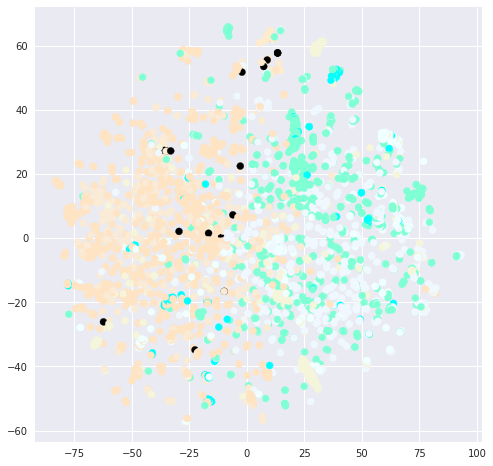

In [113]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()